In [6]:
import time
import os
import sys
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem, ttest_ind
from numpy.polynomial import polynomial
import imageio
from scipy.fft import fft
from scipy.signal import coherence, correlate, csd
import networkx as nx

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

In [7]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/PV_PPR_GABAzine_low_stim_old_rig/"
catalog_csv = data_dir + 'ppr_catalog_backup.csv'
export_csv = data_dir + 'export_summary_backup.csv'

In [8]:
# load csv files
catalog_df = pd.read_csv(catalog_csv)
catalog_df = pd.DataFrame(catalog_df)
catalog_df

,zda_file,pulse1_start,pulse1_width,pulse2_start,pulse2_width,baseline_start,baseline_width,Unnamed: 7,IPI,Notes,Stim_Current
0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,96,40,NaN,NaN,96,100,NaN,NaN,"ACSF, Control",200
1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,96,40,196.0,70.0,96,170,NaN,50.0,"ACSF, PPR",200
2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,96,40,136.0,70.0,96,110,NaN,20.0,"ACSF, PPR",200
3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,96,40,136.0,70.0,96,110,NaN,20.0,"GABAzine, PPR",200
4,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,96,40,196.0,70.0,96,170,NaN,50.0,"GABAzine, PPR",200
5,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,96,40,196.0,70.0,96,170,NaN,50.0,"ACSF, PPR",200
6,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,96,40,136.0,70.0,96,110,NaN,20.0,"ACSF, PPR",200
7,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,96,40,136.0,70.0,96,110,NaN,20.0,"GABAzine, PPR",200
8,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,96,40,196.0,70.0,96,170,NaN,50.0,"GABAzine, PPR",200


In [9]:
export_df = pd.read_csv(export_csv)
export_df = pd.DataFrame(export_df)
export_df  # home barrels are ROI 1, neighbor barrels are ROI 2

,ROI,amp,snr,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,amp_array
0,1,4.970360,21.60570,49.6253,5.74270,34.200000,53.148387,2_rois pulse1,10-22-24,2,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
1,2,3.616410,19.26260,50.5589,4.19758,48.136808,33.934853,2_rois pulse1,10-22-24,2,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
2,1,0.000000,0.00000,0.0000,14.77870,34.200000,53.148387,2_rois pulse2,10-22-24,2,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
3,2,0.000000,0.00000,0.0000,2.49493,48.136808,33.934853,2_rois pulse2,10-22-24,2,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
4,1,4.633270,16.36600,49.6962,4.90531,34.200000,53.148387,2_rois pulse1,10-22-24,2,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
5,2,3.237500,15.43400,50.4151,4.35519,48.136808,33.934853,2_rois pulse1,10-22-24,2,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
6,1,3.797310,13.59250,49.7830,4.46953,34.200000,53.148387,2_rois pulse1,10-22-24,2,1,4,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
7,2,3.465490,16.71130,50.4888,3.72748,48.136808,33.934853,2_rois pulse1,10-22-24,2,1,4,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
8,1,4.097940,7.50054,49.8295,-99.65860,34.200000,53.148387,2_rois pulse1,10-22-24,2,1,5,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
9,2,4.091760,16.15170,50.5407,4.67596,48.136808,33.934853,2_rois pulse1,10-22-24,2,1,5,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...


In [10]:
# first, look up metadata in catalog_df and append to export_df
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

def format_date(date, input_format="%m/%d/%Y", format="%m-%d-%y"):
    try:
        date = datetime.datetime.strptime(date, input_format)
        return date.strftime(format)
    except:
        return date

def format_zda(slic, loc, rec):
    """ pad to ss_ll_rr """
    slic = str(slic).zfill(2)
    loc = str(loc).zfill(2)
    rec = str(rec).zfill(2)
    return slic + '_' + loc + '_' + rec

for df in [export_df]:
    append_columns = {'ipi': [], 'drug' : [], 'num_pulses': [], "Stim_Current": [] }
    for index, row in df.iterrows():
        date = row['Date']    
        slic = row['Slice']
        location = row['Location']
        recording = row['Recording']
        file_formatted_date = format_date(date)
        zda_id = format_zda(row['Slice'], row['Location'], row['Recording'])

        # look up zda file in catalog
        zda_row = catalog_df.loc[(catalog_df['zda_file'].str.contains(file_formatted_date)) &
                                (catalog_df['zda_file'].str.contains(zda_id))]
        if len(zda_row) == 0:
            print(f"Could not find zda file for {file_formatted_date} {zda_id}")
            continue

        append_columns['ipi'].append(zda_row['IPI'].values[0])
        drug, num_pulses = zda_row['Notes'].values[0].split(',')
        stim_current = zda_row['Stim_Current'].values[0]
        append_columns['drug'].append(drug)
        append_columns['num_pulses'].append(num_pulses)
        append_columns['Stim_Current'].append(stim_current)

    # append columns to export_df
    for key, value in append_columns.items():
        df[key] = value
export_df

,ROI,amp,snr,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,amp_array,ipi,drug,num_pulses,Stim_Current
0,1,4.970360,21.60570,49.6253,5.74270,34.200000,53.148387,2_rois pulse1,10-22-24,2,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN,ACSF,Control,200
1,2,3.616410,19.26260,50.5589,4.19758,48.136808,33.934853,2_rois pulse1,10-22-24,2,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN,ACSF,Control,200
2,1,0.000000,0.00000,0.0000,14.77870,34.200000,53.148387,2_rois pulse2,10-22-24,2,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN,ACSF,Control,200
3,2,0.000000,0.00000,0.0000,2.49493,48.136808,33.934853,2_rois pulse2,10-22-24,2,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,NaN,ACSF,Control,200
4,1,4.633270,16.36600,49.6962,4.90531,34.200000,53.148387,2_rois pulse1,10-22-24,2,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,50.0,ACSF,PPR,200
5,2,3.237500,15.43400,50.4151,4.35519,48.136808,33.934853,2_rois pulse1,10-22-24,2,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,50.0,ACSF,PPR,200
6,1,3.797310,13.59250,49.7830,4.46953,34.200000,53.148387,2_rois pulse1,10-22-24,2,1,4,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20.0,ACSF,PPR,200
7,2,3.465490,16.71130,50.4888,3.72748,48.136808,33.934853,2_rois pulse1,10-22-24,2,1,4,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20.0,ACSF,PPR,200
8,1,4.097940,7.50054,49.8295,-99.65860,34.200000,53.148387,2_rois pulse1,10-22-24,2,1,5,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20.0,GABAzine,PPR,200
9,2,4.091760,16.15170,50.5407,4.67596,48.136808,33.934853,2_rois pulse1,10-22-24,2,1,5,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20.0,GABAzine,PPR,200


Date 10-22-24 Slice 2 Location 1 Recording 3
IPI 50.0 Drug ACSF ROI 1 stim_current 200
Date 10-22-24 Slice 2 Location 1 Recording 3
IPI 50.0 Drug ACSF ROI 2 stim_current 200
Date 10-22-24 Slice 2 Location 1 Recording 6
IPI 50.0 Drug GABAzine ROI 1 stim_current 200
Date 10-22-24 Slice 2 Location 1 Recording 6
IPI 50.0 Drug GABAzine ROI 2 stim_current 200


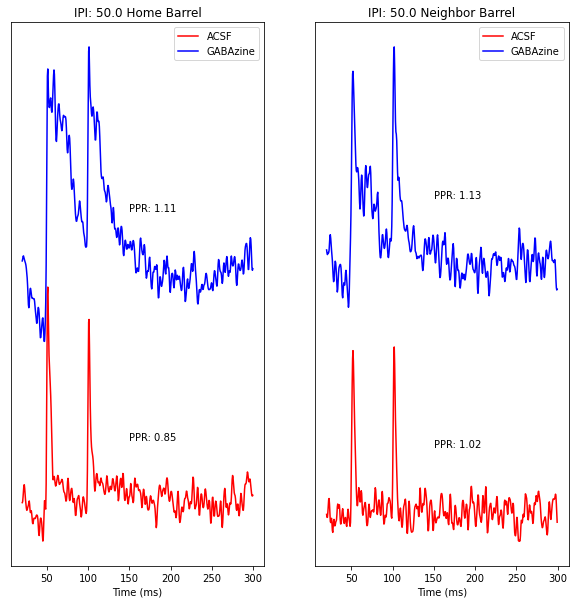

Date 10-22-24 Slice 3 Location 1 Recording 1
IPI 50.0 Drug ACSF ROI 1 stim_current 200
Date 10-22-24 Slice 3 Location 1 Recording 1
IPI 50.0 Drug ACSF ROI 2 stim_current 200
Date 10-22-24 Slice 3 Location 1 Recording 4
IPI 50.0 Drug GABAzine ROI 1 stim_current 200
Date 10-22-24 Slice 3 Location 1 Recording 4
IPI 50.0 Drug GABAzine ROI 2 stim_current 200


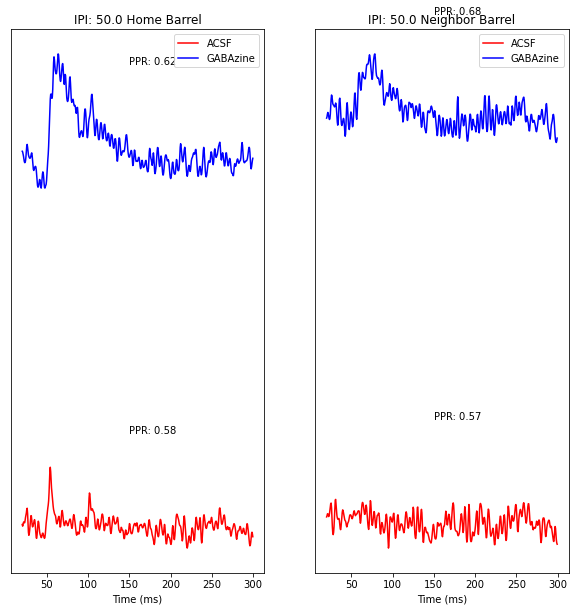

Date 10-22-24 Slice 2 Location 1 Recording 4
IPI 20.0 Drug ACSF ROI 1 stim_current 200
Date 10-22-24 Slice 2 Location 1 Recording 4
IPI 20.0 Drug ACSF ROI 2 stim_current 200
Date 10-22-24 Slice 2 Location 1 Recording 5
IPI 20.0 Drug GABAzine ROI 1 stim_current 200
Date 10-22-24 Slice 2 Location 1 Recording 5
IPI 20.0 Drug GABAzine ROI 2 stim_current 200


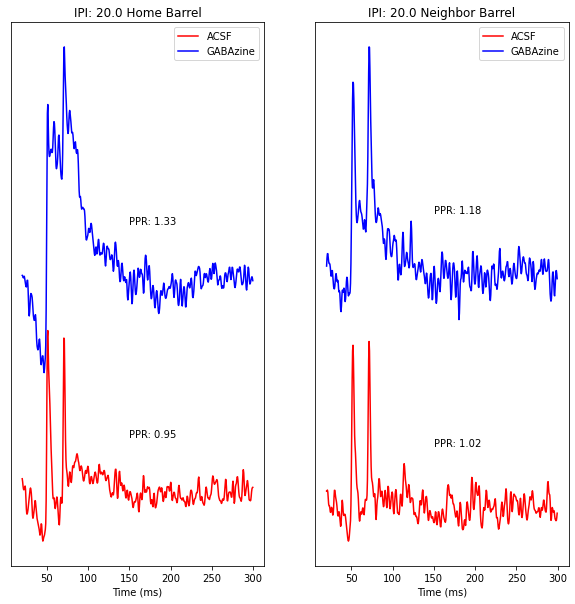

Date 10-22-24 Slice 3 Location 1 Recording 2
IPI 20.0 Drug ACSF ROI 1 stim_current 200
Date 10-22-24 Slice 3 Location 1 Recording 2
IPI 20.0 Drug ACSF ROI 2 stim_current 200
Date 10-22-24 Slice 3 Location 1 Recording 3
IPI 20.0 Drug GABAzine ROI 1 stim_current 200
Date 10-22-24 Slice 3 Location 1 Recording 3
IPI 20.0 Drug GABAzine ROI 2 stim_current 200


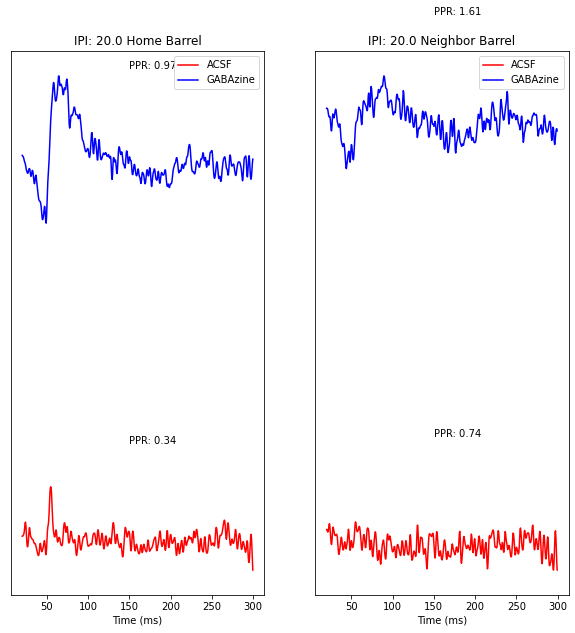

In [30]:
# for each ROI, load traces and perform summation decomposition by 
# subtracting the control trace from the paired-pulse trace.
# display the traces and the maxAmp arrays for each pulse
ppr = {}


for ipi in export_df['ipi'].unique():
    ipi_df = export_df[export_df['ipi'] == ipi]
    for slic in ipi_df['Slice'].unique():
        slic_df = ipi_df[ipi_df['Slice'] == slic]
        for loc in slic_df['Location'].unique():
            loc_df = slic_df[slic_df['Location'] == loc]
            fig, ax = plt.subplots(1, 2, figsize=(10, 10))
            for drug in loc_df['drug'].unique():
                drug_df = loc_df[loc_df['drug'] == drug]
                for roi in drug_df['ROI'].unique():
                    roi_df = drug_df[drug_df['ROI'] == roi]
                    roi_idx = 'ROI' + str(roi)

                    rec_id = roi_df['Recording'].values[0]
                    
                    ppr_row = roi_df[roi_df['num_pulses'].str.contains('PPR')]

                    ppr_trace = read_dat_trace_file(ppr_row['trace'].values[0])

                    # calculate first and second maxAmp of raw trace in measure windows
                    second_pulse_measure_window = [int(96+ipi*2), int(96+ipi*2) + 40]
                    first_pulse_measure_window = [96, 136]

                    # normalize the control traces to the max amp of the ppr traces in the first measure window

                    print("Date", ppr_row['Date'].values[0], "Slice", ppr_row['Slice'].values[0], "Location", ppr_row['Location'].values[0], "Recording", ppr_row['Recording'].values[0])
                    print("IPI", ipi, "Drug", drug, "ROI", roi, "stim_current", ppr_row['Stim_Current'].values[0])

                    # calculate PPR, ratio of second maxAmp to first maxAmp
                    ppr_val = ppr_trace[roi_idx][second_pulse_measure_window[0]:second_pulse_measure_window[1]].max() /\
                              ppr_trace[roi_idx][first_pulse_measure_window[0]:first_pulse_measure_window[1]].max()

                    plot_color = 'b' if drug == 'GABAzine' else 'r'
                    # show both traces and their subtraction (PPR - Control)
                    roi_idx = 'ROI' + str(roi)
                    baseline = 5 if drug == 'GABAzine' else 0
                    ax[roi-1].plot(ppr_trace['Pt'][40:] / 2, ppr_trace[roi_idx][40:] + baseline, label=drug, c=plot_color)
                    ax[roi-1].set_yticks([])
                    ax[roi-1].set_xlabel('Time (ms)')
                    ax[roi-1].legend()
                    # annotate with ppr_val, ppr_sub, and trace_sub_dist
                    ax[roi-1].text(150, 1.3 + baseline, 'PPR: ' + str(round(ppr_val,2)))
                    ax[roi-1].set_title('IPI: ' + str(ipi) + (" Home" if roi == 1 else " Neighbor") + " Barrel"
                        )
                    # ax.text(0.1, 0.7, 'Trace Sub Dist: ' + str(trace_sub_dist)[:6], transform=ax.transAxes)

                    
                    if ipi not in ppr:
                        ppr[ipi] = {}
                    if drug not in ppr[ipi]:
                        ppr[ipi][drug] = {}
                    if roi not in ppr[ipi][drug]:
                        ppr[ipi][drug][roi] = {}
                    ppr[ipi][drug][roi]['ppr_raw'] = ppr_val
            #if slic == 2 and rec_id in [2, 5]:
            #    plt.savefig("P:/John/F31 resubmission/figures/input/" + str(ipi) + "ms_" + drug + "_ROI" + str(roi) + ".png")
            plt.show()
